In [247]:
import requests
import pickle
import pandas as pd
import json as js
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from matplotlib.dates import DateFormatter, date2num

In [96]:
players_df = pd.concat(map(pd.read_csv, ['players_df_500.csv', 'players_df_1082.csv']))
teams_df = pd.concat(map(pd.read_csv, ['teams_df_500.csv', 'teams_df_1082.csv']))
teams_df = teams_df.drop_duplicates()
teams_df = teams_df.sort_values('id')
games_df = pd.concat(map(pd.read_csv, ['games_df_500.csv', 'games_df_1082.csv']))
#events_df = pd.read_csv('events_df.csv')
#players_df
#teams_df
#games_df
#events_df

In [201]:
events_df = pd.concat(map(pd.read_csv, ['events_df_500.csv', 'events_df_1082.csv']))

In [202]:
#Nullas sorok feltoltese hogy utana int-re valtoztathassuk
events_df = events_df.fillna(0)
events_df = events_df.astype({'player1Id': 'int64','player2Id':'int64','player3Id':'int64','player4Id':'int64'})

In [186]:
events_df.dtypes
#events_df

gameId             int64
eventId            int64
eventType         object
eventTypeDesc     object
period             int64
periodTime        object
periodType        object
teamAwayID         int64
teamHomeID         int64
goalsHome          int64
goalsAway          int64
coX              float64
coY              float64
player1Id          int64
player1Type       object
player2Id          int64
player2Type       object
player3Id          int64
player3Type       object
player4Id          int64
player4Type       object
dtype: object

In [203]:
#A periodTime konvertalasa Timedelta tipusra
events_df['periodTime'] = pd.to_timedelta(events_df['periodTime'].apply(lambda x: f'00:{x}'))
events_df

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,coX,coY,player1Id,player1Type,player2Id,player2Type,player3Id,player3Type,player4Id,player4Type
0,2019020001,0,Game Scheduled,Game Scheduled,1,0 days 00:00:00,REGULAR,9,10,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,2019020001,1,Period Ready,Period Ready,1,0 days 00:00:00,REGULAR,9,10,0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,2019020001,2,Period Start,Period Start,1,0 days 00:00:00,REGULAR,9,10,0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,2019020001,3,Faceoff,John Tavares faceoff won against Colin White,1,0 days 00:00:00,REGULAR,9,10,0,...,0.0,0.0,8475166,Winner,8478400,Loser,0,0,0,0
4,2019020001,4,Goal,"Brady Tkachuk (1) Tip-In, assists: Connor Brow...",1,0 days 00:00:25,REGULAR,9,10,0,...,85.0,-1.0,8480801,Scorer,8477015,Assist,8478400,Assist,8475883,Goalie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183653,2019021082,303,Blocked Shot,Martin Frk shot blocked shot by Anthony Duclair,3,0 days 00:19:47,REGULAR,9,26,3,...,-51.0,-27.0,8477407,Blocker,8476924,Shooter,0,0,0,0
183654,2019021082,304,Period End,End of 3rd Period,3,0 days 00:20:00,REGULAR,9,26,3,...,0.0,0.0,0,0,0,0,0,0,0,0
183655,2019021082,305,Period Official,Period Official,3,0 days 00:20:00,REGULAR,9,26,3,...,0.0,0.0,0,0,0,0,0,0,0,0
183656,2019021082,306,Game End,Game End,3,0 days 00:20:00,REGULAR,9,26,3,...,0.0,0.0,0,0,0,0,0,0,0,0


In [6]:
#Data Exploratory: Atlagos eletkor
avg_age = pd.DataFrame()
avg_age = round(players_df.groupby('teamID')['currentAge'].mean(),1).sort_values()
teamsname = teams_df[['id','name']]
agebyteams = pd.merge(left=avg_age, right=teamsname, left_on='teamID', right_on='id', how='left')
agebyteams

,currentAge,id,name
0,28.2,3,New York Rangers
1,28.3,12,Carolina Hurricanes
2,28.3,7,Buffalo Sabres
3,28.3,29,Columbus Blue Jackets
4,28.4,52,Winnipeg Jets
5,28.7,1,New Jersey Devils
6,28.7,10,Toronto Maple Leafs
7,28.8,21,Colorado Avalanche
8,29.1,24,Anaheim Ducks
9,29.2,4,Philadelphia Flyers


Text(0.5, 0, 'Kor')

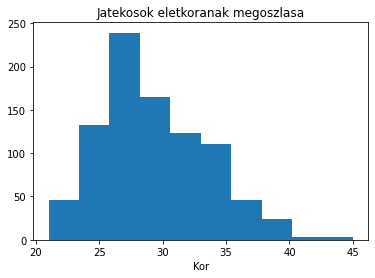

In [95]:
#Data Exploratory: Atlagos eletkor histogram
playersage = players_df[['id','currentAge']]
playersage = playersage.drop_duplicates()
playersage = playersage.drop(columns=['id'])
plt.hist(playersage)
plt.title('Jatekosok eletkoranak megoszlasa')
plt.xlabel('Kor')

In [562]:
#Uj dataframe meghatarozott ember meghatarozott esemenyeivel
sog_df = pd.DataFrame()
sog_df = events_df[events_df['eventType'].isin(['Shot','Goal'])]
sog_df = sog_df[sog_df['player1Id'].isin([8471214])]
sog_df = sog_df.drop_duplicates()
sog_df = sog_df.astype({'coX': 'int64','coY':'int64'})
sog_df

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,coX,coY,player1Id,player1Type,player2Id,player2Type,player3Id,player3Type,player4Id,player4Type
448,2019020002,66,Goal,"Alex Ovechkin (1) Snap Shot, assists: John Car...",1,0 days 00:15:37,REGULAR,15,19,2,...,-57,18,8471214,Scorer,8474590,Assist,8474189,Assist,8476412,Goalie
523,2019020002,141,Shot,Alex Ovechkin Backhand saved by Jordan Binnington,2,0 days 00:08:53,REGULAR,15,19,2,...,91,-27,8471214,Shooter,8476412,Goalie,0,0,0,0
606,2019020002,224,Shot,Alex Ovechkin Tip-In saved by Jordan Binnington,3,0 days 00:03:25,REGULAR,15,19,2,...,-78,3,8471214,Shooter,8476412,Goalie,0,0,0,0
638,2019020002,256,Shot,Alex Ovechkin Slap Shot saved by Jordan Binnin...,3,0 days 00:10:49,REGULAR,15,19,2,...,-52,25,8471214,Shooter,8476412,Goalie,0,0,0,0
664,2019020002,282,Shot,Alex Ovechkin Wrist Shot saved by Jordan Binni...,3,0 days 00:18:05,REGULAR,15,19,2,...,-68,34,8471214,Shooter,8476412,Goalie,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178357,2019021066,130,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,2,0 days 00:09:52,REGULAR,15,7,2,...,53,29,8471214,Shooter,8476999,Goalie,0,0,0,0
178416,2019021066,189,Goal,"Alex Ovechkin (48) Wrist Shot, assists: Evgeny...",3,0 days 00:03:33,REGULAR,15,7,2,...,-68,-1,8471214,Scorer,8475744,Assist,8476999,Goalie,0,0
178442,2019021066,215,Shot,Alex Ovechkin Backhand saved by Linus Ullmark,3,0 days 00:08:43,REGULAR,15,7,2,...,-80,-1,8471214,Shooter,8476999,Goalie,0,0,0,0
178484,2019021066,257,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,3,0 days 00:19:02,REGULAR,15,7,2,...,-59,7,8471214,Shooter,8476999,Goalie,0,0,0,0


In [563]:
#Tukrozzuk az esemenyeket az origora
for idx, i in enumerate(sog_df['coX']):
    if i<0:
        sog_df['coX'].iloc[idx] = abs(sog_df['coX'].iloc[idx])
        sog_df['coY'].iloc[idx] = sog_df['coY'].iloc[idx]*-1
sog_df

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/939347683.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/939347683.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,coX,coY,player1Id,player1Type,player2Id,player2Type,player3Id,player3Type,player4Id,player4Type
448,2019020002,66,Goal,"Alex Ovechkin (1) Snap Shot, assists: John Car...",1,0 days 00:15:37,REGULAR,15,19,2,...,57,-18,8471214,Scorer,8474590,Assist,8474189,Assist,8476412,Goalie
523,2019020002,141,Shot,Alex Ovechkin Backhand saved by Jordan Binnington,2,0 days 00:08:53,REGULAR,15,19,2,...,91,-27,8471214,Shooter,8476412,Goalie,0,0,0,0
606,2019020002,224,Shot,Alex Ovechkin Tip-In saved by Jordan Binnington,3,0 days 00:03:25,REGULAR,15,19,2,...,78,-3,8471214,Shooter,8476412,Goalie,0,0,0,0
638,2019020002,256,Shot,Alex Ovechkin Slap Shot saved by Jordan Binnin...,3,0 days 00:10:49,REGULAR,15,19,2,...,52,-25,8471214,Shooter,8476412,Goalie,0,0,0,0
664,2019020002,282,Shot,Alex Ovechkin Wrist Shot saved by Jordan Binni...,3,0 days 00:18:05,REGULAR,15,19,2,...,68,-34,8471214,Shooter,8476412,Goalie,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178357,2019021066,130,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,2,0 days 00:09:52,REGULAR,15,7,2,...,53,29,8471214,Shooter,8476999,Goalie,0,0,0,0
178416,2019021066,189,Goal,"Alex Ovechkin (48) Wrist Shot, assists: Evgeny...",3,0 days 00:03:33,REGULAR,15,7,2,...,68,1,8471214,Scorer,8475744,Assist,8476999,Goalie,0,0
178442,2019021066,215,Shot,Alex Ovechkin Backhand saved by Linus Ullmark,3,0 days 00:08:43,REGULAR,15,7,2,...,80,1,8471214,Shooter,8476999,Goalie,0,0,0,0
178484,2019021066,257,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,3,0 days 00:19:02,REGULAR,15,7,2,...,59,-7,8471214,Shooter,8476999,Goalie,0,0,0,0


In [564]:
#Shot distance and angle
goalcenter_x = 89
goalcenter_y = 0

sog_df['shot_angle'] = sog_df[['coX','coY']].apply(
    lambda row: np.arctan(row['coY']/(89-row['coX']))*(180/np.pi),
    axis=1)

sog_df['shot_distance'] = sog_df[['coX','coY']].apply(
    lambda row: np.sqrt((row['coX']-goalcenter_x)**2 + (row['coY']-goalcenter_y)**2), axis=1)

sog_df

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3955655225.py:6: RuntimeWarning:

divide by zero encountered in long_scalars



,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,player1Id,player1Type,player2Id,player2Type,player3Id,player3Type,player4Id,player4Type,shot_angle,shot_distance
448,2019020002,66,Goal,"Alex Ovechkin (1) Snap Shot, assists: John Car...",1,0 days 00:15:37,REGULAR,15,19,2,...,8471214,Scorer,8474590,Assist,8474189,Assist,8476412,Goalie,-29.357754,36.715120
523,2019020002,141,Shot,Alex Ovechkin Backhand saved by Jordan Binnington,2,0 days 00:08:53,REGULAR,15,19,2,...,8471214,Shooter,8476412,Goalie,0,0,0,0,85.763605,27.073973
606,2019020002,224,Shot,Alex Ovechkin Tip-In saved by Jordan Binnington,3,0 days 00:03:25,REGULAR,15,19,2,...,8471214,Shooter,8476412,Goalie,0,0,0,0,-15.255119,11.401754
638,2019020002,256,Shot,Alex Ovechkin Slap Shot saved by Jordan Binnin...,3,0 days 00:10:49,REGULAR,15,19,2,...,8471214,Shooter,8476412,Goalie,0,0,0,0,-34.045937,44.654227
664,2019020002,282,Shot,Alex Ovechkin Wrist Shot saved by Jordan Binni...,3,0 days 00:18:05,REGULAR,15,19,2,...,8471214,Shooter,8476412,Goalie,0,0,0,0,-58.298570,39.962482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178357,2019021066,130,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,2,0 days 00:09:52,REGULAR,15,7,2,...,8471214,Shooter,8476999,Goalie,0,0,0,0,38.853374,46.227697
178416,2019021066,189,Goal,"Alex Ovechkin (48) Wrist Shot, assists: Evgeny...",3,0 days 00:03:33,REGULAR,15,7,2,...,8471214,Scorer,8475744,Assist,8476999,Goalie,0,0,2.726311,21.023796
178442,2019021066,215,Shot,Alex Ovechkin Backhand saved by Linus Ullmark,3,0 days 00:08:43,REGULAR,15,7,2,...,8471214,Shooter,8476999,Goalie,0,0,0,0,6.340192,9.055385
178484,2019021066,257,Shot,Alex Ovechkin Wrist Shot saved by Linus Ullmark,3,0 days 00:19:02,REGULAR,15,7,2,...,8471214,Shooter,8476999,Goalie,0,0,0,0,-13.134022,30.805844


(-42.5, 42.5)

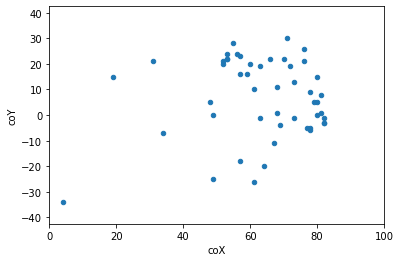

In [112]:
#Kirajzoljuk a koordinatakat

sog_df.plot(x="coX", y="coY", kind="scatter",colormap="YlOrRd")
plt.xlim(0,100)
plt.ylim(-42.5,42.5)

#Igy is lehet:
#x = sog_df['coX']
#y = sog_df['coY']
#plt.xlim(0,100)
#plt.ylim(-42.5,42.5)
#plt.scatter(x, y)

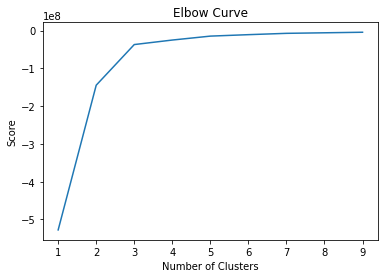

In [23]:
#Meghatarozzuk, hany klaszter erdemes letrehozni
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = events_df[['coX']]
X_axis = events_df[['coY']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [565]:
#Letrehozunk egy uj dataframet a vizualizaciohoz az x es y koordinatakkal
X = sog_df.loc[:,['coX','coY']]

#Kerekites:
#for idx, i in X.iterrows():
#    X.loc[idx,'coX'] = int(round(X.loc[idx,'coX']/10.0)*10.0)
#    X.loc[idx,'coY'] = int(round(X.loc[idx,'coY']/10.0)*10.0)

X

,coX,coY
448,57,-18
523,91,-27
606,78,-3
638,52,-25
664,68,-34
...,...,...
178357,53,29
178416,68,1
178442,80,1
178484,59,-7


In [566]:
#A meghatarozott klaszterszamot megadva klaszterekbe soroljuk a koordinatakat
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point
X

,coX,coY,cluster_label
448,57,-18,0
523,91,-27,2
606,78,-3,2
638,52,-25,0
664,68,-34,0
...,...,...,...
178357,53,29,1
178416,68,1,2
178442,80,1,2
178484,59,-7,0


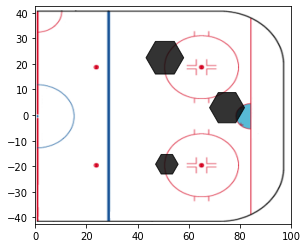

In [597]:
#Kiszamoljuk a pottyok meretet, a klaszterek elemszamat vesszuk es megszorozzuk valamennyiel, hogy nagyobb legyen.
size = X.groupby(['cluster_label']).count()
size = size['coX']*10

#Ket valtozot inicializalunk aminek megadjuk az X es Y oszlopunkat, hogy kesobb be tudjuk taplalni a plot-ba
coX = X['coX']
coY = X['coY']
img = plt.imread("Half_ice_hockey_rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 100, -42.5, 42.5])
#ax.scatter(coX, coY)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=size, marker='H', alpha=0.8)
plt.xlim(0,100)
plt.ylim(-42.5,42.5)
plt.show()

In [409]:
#Goal - Assist pairs
Y = sog_df.loc[:,['player1Id','player2Id']]
Y = Y.groupby(['player1Id', 'player2Id']).size().sort_values(ascending=False).reset_index(name='count') 
Y

,player1Id,player2Id,count
0,8471214,8474590,14
1,8471214,8475744,8
2,8471214,8473563,6
3,8471214,8475200,6
4,8471214,8476880,5
5,8471214,8471698,4
6,8471214,0,1
7,8471214,8469454,1
8,8471214,8476316,1
9,8471214,8477424,1


/Users/sszavai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



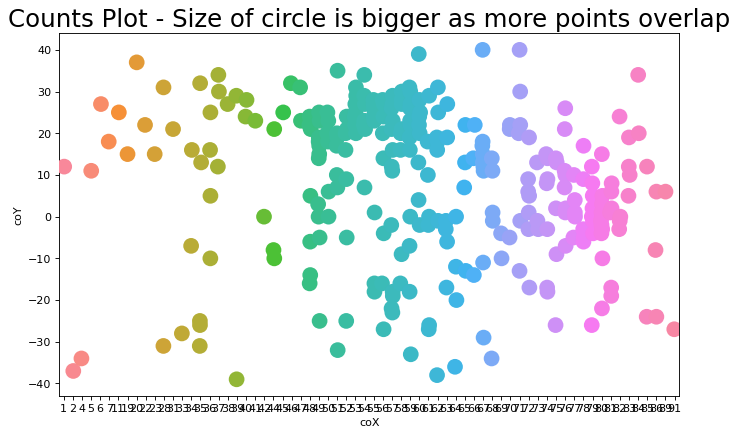

In [568]:
df_counts = X.groupby(['coY', 'coX']).size().reset_index(name='counts')
# Draw Stripplot
fig, ax = plt.subplots(figsize=(10,6), dpi= 80)    
sb.stripplot(df_counts.coX, df_counts.coY, sizes=df_counts.counts*200, ax=ax)

# Decorations
plt.title('Counts Plot - Size of circle is bigger as more points overlap', fontsize=22)
#plt.xlim(0,100)
#plt.ylim(-42.5,42.5)
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

In [569]:
df_counts = X.groupby(['coY', 'coX']).size().reset_index(name='counts')
df_counts['counts2'] = df_counts['counts'] * 2
fig = px.scatter(df_counts, x='coX', y='coY',
                 color='counts2',
                 size='counts2')
fig.update_layout(yaxis_range=[-42.5,42.5])
fig.update_layout(xaxis_range=[0,100])

# Remove side scale and hide zero and gridlines
#fig.update_layout(
 #   coloraxis_showscale=False,
  #  xaxis=dict(showgrid=False, zeroline=False),
   # yaxis=dict(showgrid=False, zeroline=False),)
# Disable axis ticks and labels
#fig.update_xaxes(showticklabels=False)
#fig.update_yaxes(showticklabels=False)
#fig.update_xaxes(title_text='')
#fig.update_yaxes(title_text='')

fig.update_layout(template="plotly_white")
#fig.show()

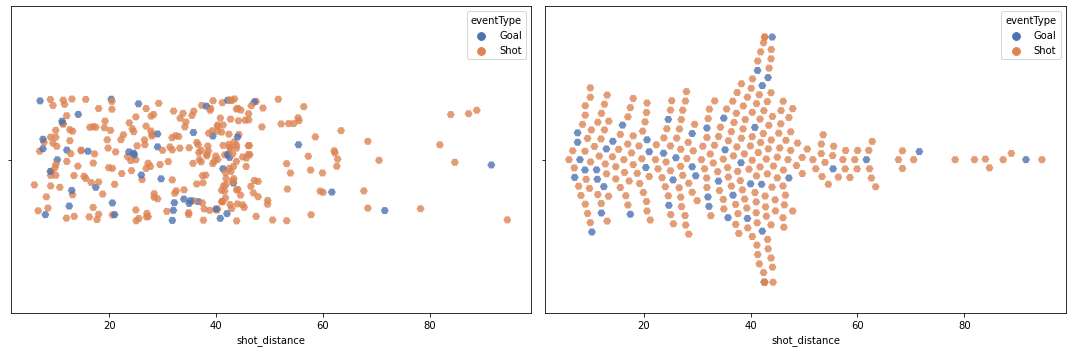

In [618]:
dist = pd.DataFrame()
dist = sog_df[['shot_distance','player1Id','eventType']]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sb.stripplot(data=dist, x=dist['shot_distance'], y=[""]*len(dist), ax=ax1, hue=dist['eventType'],palette="deep", 
             size=8, marker="H", edgecolor="gray", alpha=.8, jitter = .2)

sb.swarmplot(data=dist, x=dist['shot_distance'], ax=ax2,  y=[""]*len(dist), hue=dist['eventType'],palette="deep", 
             size=8, marker="H",edgecolor="gray", alpha=.8)

plt.tight_layout()

In [632]:
#events_df.player1Type.unique() #'Winner', 'Scorer', 'Shooter', 'PenaltyOn', 'PlayerID','Blocker', 'Hitter'
#events_df.player2Type.unique() #'Loser', 'Assist', 'DrewBy', 'Goalie', 'Shooter', 'Hittee'
#events_df.player3Type.unique() #'Assist', 'Goalie', 'ServedBy'
#events_df.player4Type.unique() #'Golie'
events_df.eventType.unique()

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff',
       'Goal', 'Missed Shot', 'Stoppage', 'Penalty', 'Giveaway', 'Shot',
       'Blocked Shot', 'Hit', 'Takeaway', 'Period End', 'Period Official',
       'Official Challenge', 'Game End', 'Game Official',
       'Shootout Complete', 'Early Intermission Start',
       'Early Intermission End', 'Emergency Goaltender'], dtype=object)